In [53]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from itertools import product
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [75]:
data = pd.read_csv('allBank.csv')

In [76]:
def rmse(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [77]:
# data.head(8)

In [78]:
data = data[(data.bank_group_id==1)]
data = data[data.sector_id.isin([1,2,3,4])]

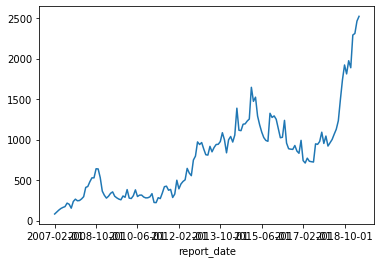

In [79]:
data = data.groupby('report_date').sum().value_rub
data.plot()

In [80]:
def rmse(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
data.index = pd.to_datetime(data.index)
data = data.to_frame()
data.head()

,value_rub
report_date,
2007-02-01,82.580155
2007-03-01,105.853892
2007-04-01,130.690753
2007-05-01,150.535440
2007-06-01,163.969009


In [82]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y+1)/lmbda)

Критерий Дики-Фуллера: 0.994667


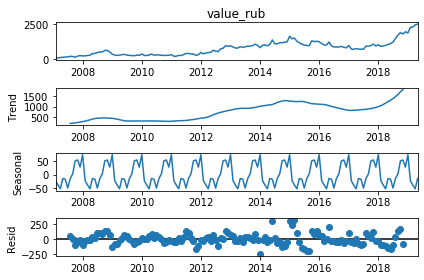

In [83]:
sm.tsa.seasonal_decompose(data.value_rub).plot()
print('Критерий Дики-Фуллера: {:.6f}'.format(sm.tsa.stattools.adfuller(data.value_rub)[1]))

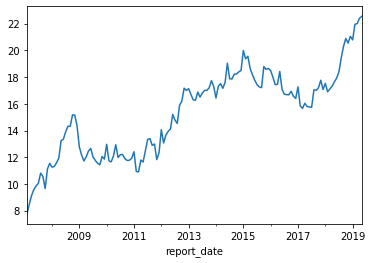

In [84]:
data['value_rub_bc'] , lmbda = stats.boxcox(data.value_rub)
data.value_rub_bc.plot()

Критерий Дики-Фуллера: 0.383340


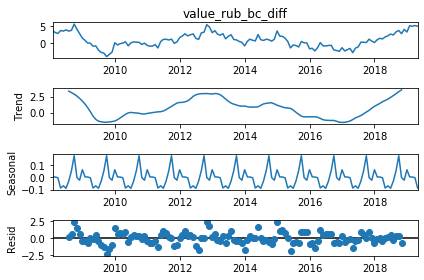

In [85]:
data['value_rub_bc_diff'] = data.value_rub_bc - data.value_rub_bc.shift(12)
sm.tsa.seasonal_decompose(data.value_rub_bc_diff[12:]).plot()
print('Критерий Дики-Фуллера: {:.6f}'.format(sm.tsa.stattools.adfuller(data.value_rub_bc_diff[12:])[1]))

Критерий Дики-Фуллера: 0.001357


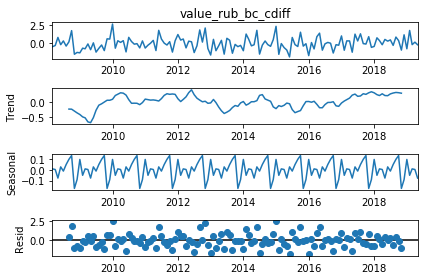

In [87]:
data['value_rub_bc_cdiff'] = data.value_rub_bc_diff - data.value_rub_bc_diff.shift(1)
sm.tsa.seasonal_decompose(data.value_rub_bc_cdiff[13:]).plot()
print('Критерий Дики-Фуллера: {:.6f}'.format(sm.tsa.stattools.adfuller(data.value_rub_bc_cdiff[13:])[1]))

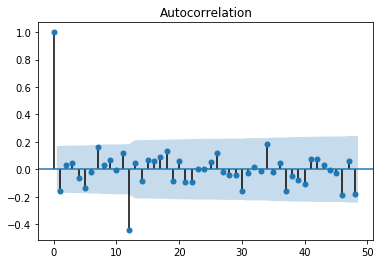

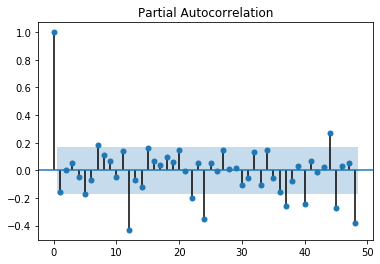

In [88]:
ax = plt.subplot()
sm.graphics.tsa.plot_acf(data.value_rub_bc_cdiff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot()
sm.graphics.tsa.plot_pacf(data.value_rub_bc_cdiff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

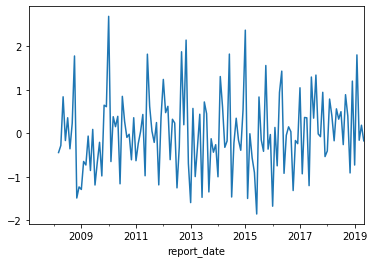

In [89]:
data.value_rub_bc_cdiff.plot()

In [113]:
train = data.iloc[:-12, :]
test = data.iloc[-12:, :]

ps = range(0, 4)
d = 1
qs = range(0, 4)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [135]:
%%time
results = []
best_aic = float('inf')

for param in parameters_list:

    model = sm.tsa.statespace.SARIMAX(train.value_rub_bc, 
                                      order=(param[0], d, param[1]),
                                      seasonal_order=(param[2], D, param[3], 12)).fit()

    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 35.5 s


In [136]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True))

      parameters         aic
37  (2, 1, 0, 1)  263.939982
61  (3, 3, 0, 1)  264.633813
1   (0, 0, 0, 1)  265.083671
5   (0, 1, 0, 1)  265.577959
29  (1, 3, 0, 1)  265.742674
..           ...         ...
8   (0, 2, 0, 0)  325.794547
20  (1, 1, 0, 0)  325.796375
48  (3, 0, 0, 0)  327.388951
12  (0, 3, 0, 0)  327.663328
52  (3, 1, 0, 0)  329.317929

[64 rows x 2 columns]


In [137]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       value_rub_bc   No. Observations:                  136
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -126.970
Date:                            Tue, 28 Jul 2020   AIC                            263.940
Time:                                    19:46:18   BIC                            278.001
Sample:                                02-01-2007   HQIC                           269.651
                                     - 05-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0085      0.098    -10.257      0.000      -1.201      -0.816
ar.L2         -0.1744      0.096   

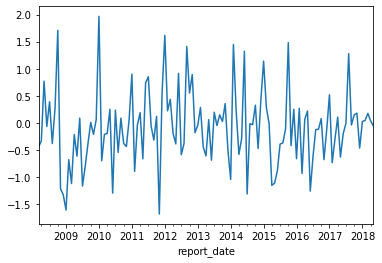

In [138]:
best_model.resid[13:].plot()

In [139]:
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
print("Критерий Стьюдента: p={:.6f}".format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print("Критерий Дики-Фуллера: p={:.6f}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

Критерий Стьюдента: p=0.175772
Критерий Дики-Фуллера: p=0.000000


In [140]:
data_ = data[['value_rub']][:-12]
date_list = [dt.datetime.strptime('2018-06-01', "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns=data_.columns)
data_ = pd.concat([data_, future])

In [141]:
data_[-12:].value_rub = invboxcox(best_model.predict(start=train.shape[0], end=data.shape[0]), lmbda)

In [142]:
actual = data.value_rub.tail(12).values
predicted = data_.value_rub.tail(12).values

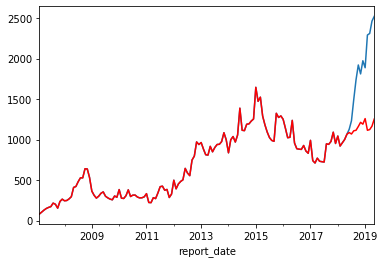

In [143]:
data.value_rub.plot()
data_.value_rub.plot(color='r')

In [144]:
rmse(actual, predicted)

35.78929951346139